In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Plotting tools

Below, we define some useful plotting functions to assist us.

In [24]:
def stem_plot(ax, x, y, title = '', xlabel = '', ylabel = '', ylim = None):
    ax.stem(x, y)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.grid()

# Low rank approximation

## Plotting the ACF

Let $k:\mathbb{N}\to\mathbb{R}$ be an autocovariance function (ACF). Given a max time lag $T$, we begin by plotting the values
$$
    [k(-T),\dots,k(-1),k(0),k(1),\dots,k(T)] = [k(T),\dots,k(1),k(0),k(1),\dots,k(T)]
$$
We denote the total length of this sequence by $N\coloneqq 2T+1$. Here, we will focus on the simple example of the RBF kernel given by
$$
    k(\tau) \coloneqq \exp\left(-\frac{\tau^2}{2l^2}\right)
$$
for some parameter $l$.

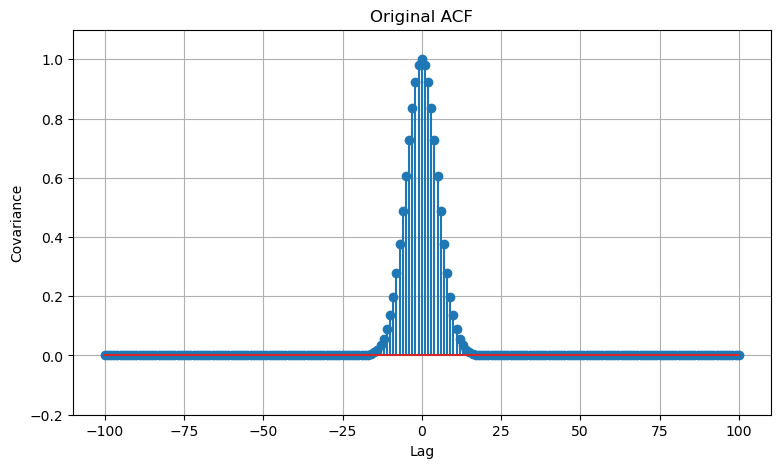

In [25]:
T = 100             # Maximum time lag
N = 2 * T + 1       # Number of points in the ACF

# Define RBF ACF
lengthscale = 5     # Lengthscale of the ACF
k = [0] * N         # Initialize the ACF
for tau in range(T + 1):
    k[T + tau] = k[T - tau] = np.exp(-0.5 * (tau / lengthscale) ** 2)

lags = np.arange(-T, T+1)

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k, "Original ACF", "Lag", "Covariance", (-0.2, 1.1))

## Compute the DFT of the ACF

Our first task is to take the DFT of the ACF $k$ defined previously. To preserve evenness of the input signal, we must shift the ACF vector appropriately. Namely, we will take the DFT of the following sequence:
$$
    [k(0),k(1),\dots,k(T),k(T),\dots,k(1)]
$$
We will call this the *shifted* ACF, as opposed to the original *centered* one. This ensures that the DFT is real-valued and of the form
$$
\begin{equation}
    S(m) = k(0) + 2 \sum_{t=1}^T k(t) \cos\left(2\pi\frac{m}{N}t\right) 
\end{equation}
$$
In addition, the DFT vector is symmetric:
$$
    S = [S(0),S(1),\dots,S(T),S(T),\dots,S(1)]
$$
As a first step, let us understand how the shifting operations `np.fft.fftshift` and `np.fft.ifftshift` work.

In [26]:
# Toy example to understand shifting operation
arr1 = np.array([0, 1, 2, 2, 1])
arr2 = np.array([2, 1, 0, 1, 2])
print(f'Shift: {arr1} --> {np.fft.fftshift(arr1)}')
print(f'Inverse shift: {arr2} --> {np.fft.ifftshift(arr2)}')

Shift: [0 1 2 2 1] --> [2 1 0 1 2]
Inverse shift: [2 1 0 1 2] --> [0 1 2 2 1]


Hence, we must 
1. Inverse-shift the ACF to get the shifted ACF.
2. Take the DFT, which yields a shifted vector. Note that we must explicitly take the real part to further manipulate it.
3. Shift the DFT for plotting.

<!-- For 3, note that $S(m)$ corresponds to frequency $2\pi m/N$ -->
> TODO: explain frequency axis


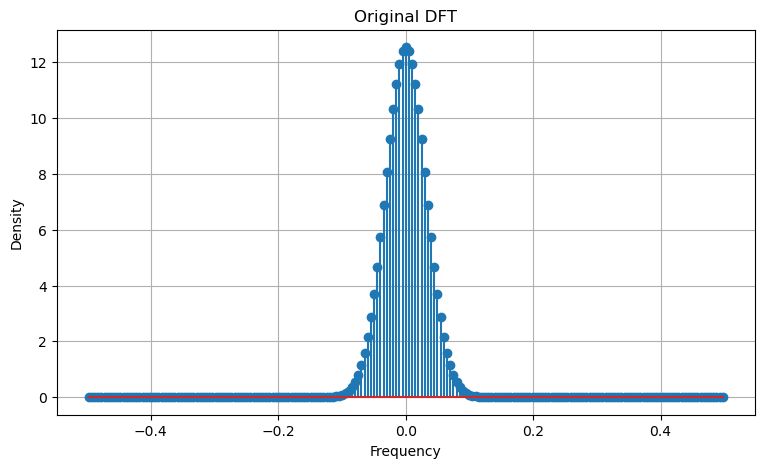

In [27]:
k_shifted = np.fft.ifftshift(k)                                         # Shifted ACF          
spectrum_shifted = np.real(np.fft.fft(k_shifted))                       # Shifted DFT
spectrum = np.fft.fftshift(spectrum_shifted)                            # Centered DFT
Omega = np.fft.fftshift(np.fft.fftfreq(N))                              # Centered frequencies

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, Omega, spectrum, "Original DFT", "Frequency", "Density")

As a sanity check, let us compare the result above with the explicit DFT formula (1).

In [28]:
S = np.fft.fftshift([k_shifted[0] + 2 * sum([k_shifted[t] * np.cos(2 * np.pi * m * t / N) for t in range(1, T + 1)]) for m in range(N)])
print('Mean difference:', np.mean(spectrum - S))

Mean difference: 5.340345876801345e-16


## Get top modes

Next, we want to take the DFT and set to 0 all but the top $r$ values.

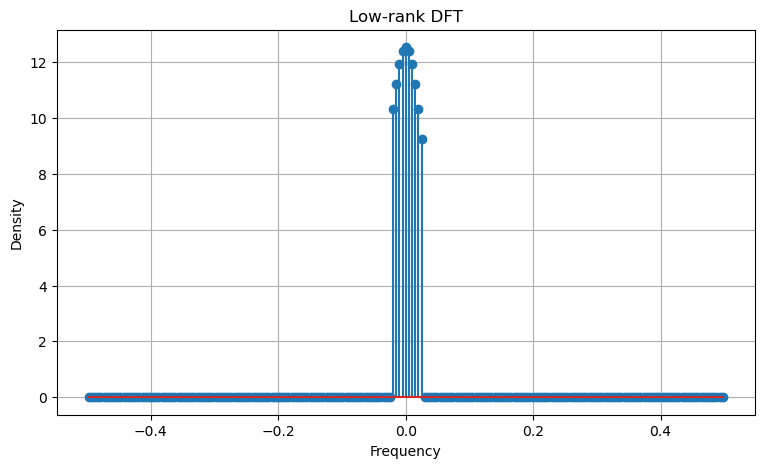

In [29]:
r = 10      # Number of modes

# Mask the spectrum
lr_spectrum_shifted = spectrum_shifted.copy()
lr_spectrum_shifted[lr_spectrum_shifted < np.sort(lr_spectrum_shifted)[-r]] = 0

# Shift the spectrum and plot
lr_spectrum = np.fft.fftshift(lr_spectrum_shifted)

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, Omega, lr_spectrum, "Low-rank DFT", "Frequency", "Density")


## Reconstruct low-rank ACF

The masked DFT yields a low-rank ACF $k_\text{LR}$, which we can obtain by taking the inverse DFT.

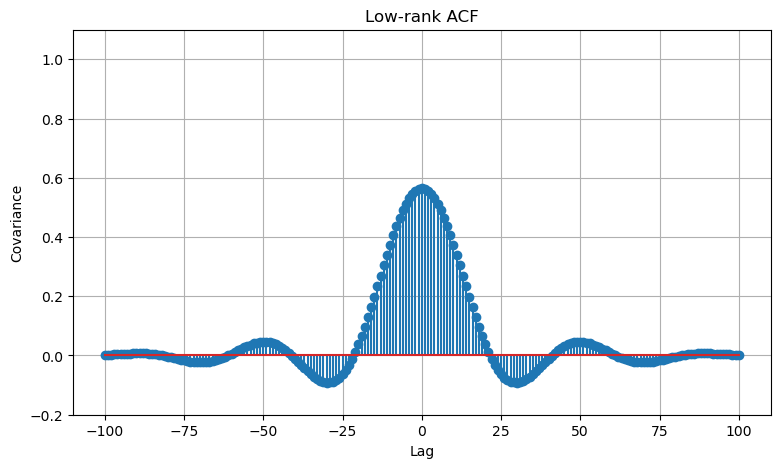

In [30]:
k_lr = np.fft.fftshift(np.real(np.fft.ifft(lr_spectrum_shifted)))   # Low-rank ACF

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k_lr, "Low-rank ACF", "Lag", "Covariance", (-0.2, 1.1))

Finally, we plot all pieces side-by-side for visualization.

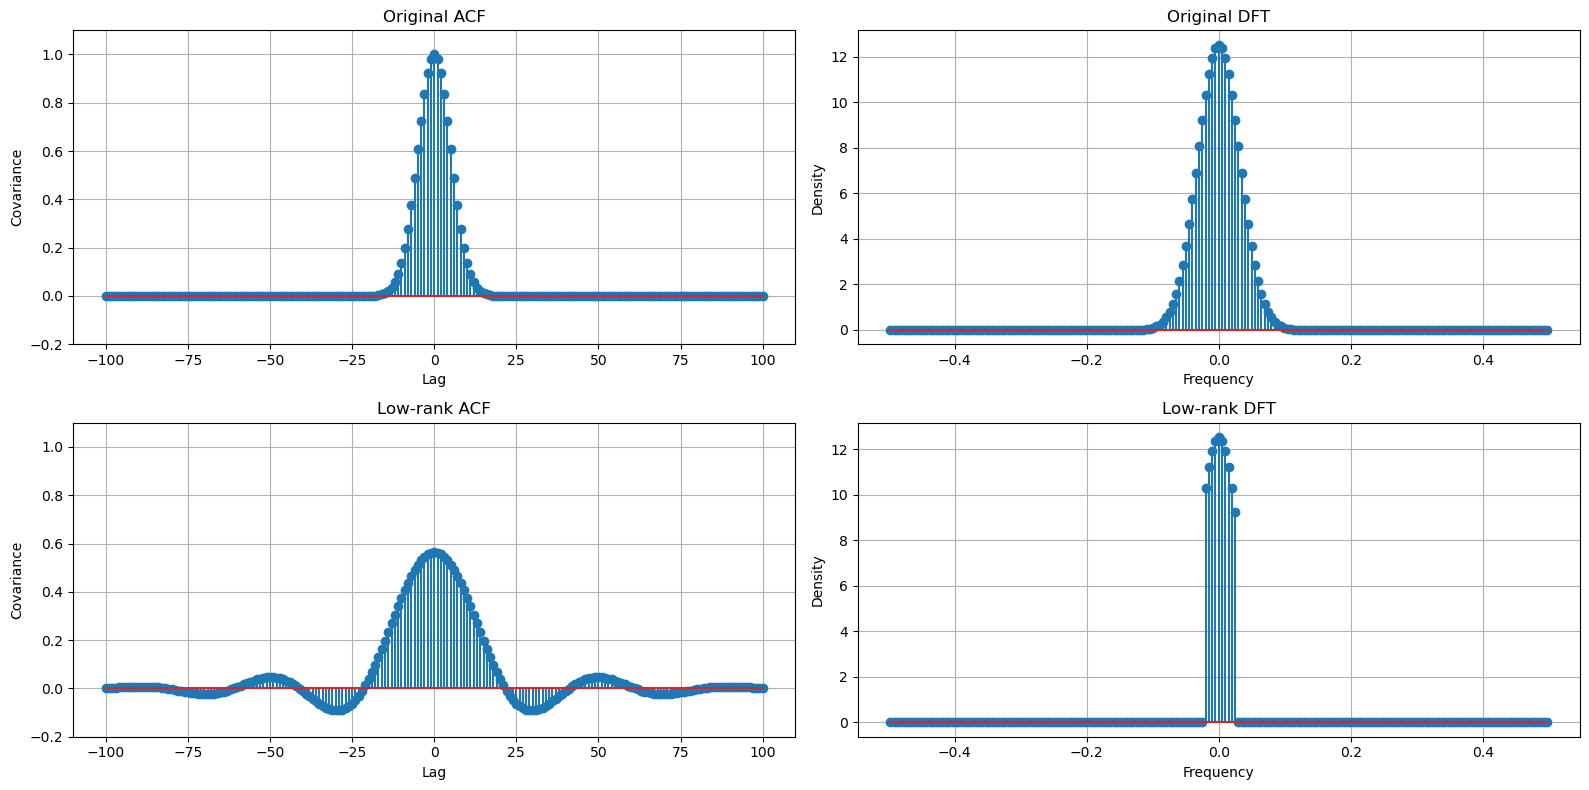

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

stem_plot(ax[0][0], lags, k, "Original ACF", "Lag", "Covariance", (-0.2, 1.1))
stem_plot(ax[0][1], Omega, spectrum, "Original DFT", "Frequency", "Density")
stem_plot(ax[1][1], Omega, lr_spectrum, "Low-rank DFT", "Frequency", "Density")
stem_plot(ax[1][0], lags, k_lr, "Low-rank ACF", "Lag", "Covariance", (-0.2, 1.1))
plt.tight_layout()

# Sparse approximation

Notice the discrepancy between the original ACF and its low-rank approximation. Evidently, we were unable to capture the peaks at small lags. To mitigate this issue, we will fit the residual ACF $k_\text{res} = k-k_\text{LR}$ with a moving average ACF of order $q$. Let us begin by plotting the residual ACF.

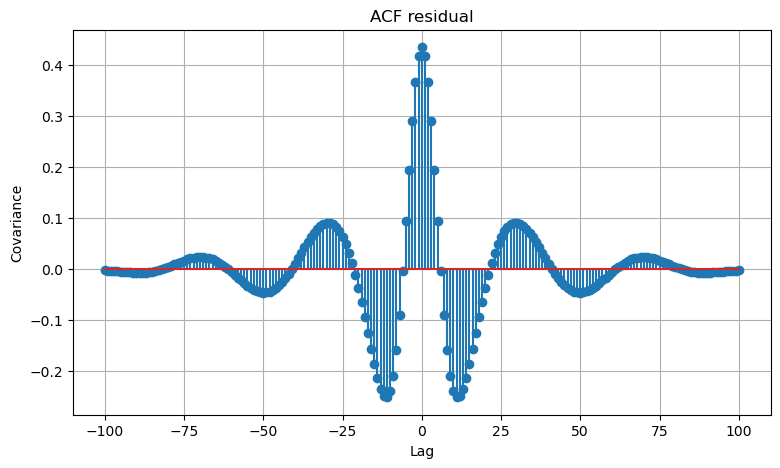

In [32]:
k_res = k - k_lr  # Residual ACF

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k_res, "ACF residual", "Lag", "Covariance")

Recall that the $\text{MA}(q)$ ACF, under parameter $\theta=(\theta_0,\dots,\theta_q)$, is given by
$$
    k_\text{MA}(\tau;\theta) = \sum_{m=0}^{q-\tau} \theta_m \theta_{m+\tau}
$$
Our goal is to find the $\theta$ that best fits the residual ACF in $\ell_2$ distance:
$$
    \theta^* = \argmin_{\theta\in\mathbb{R}^{q+1}} \Vert k_\text{res}-k_\text{MA}(\cdot;\theta) \Vert_2
$$
This then yields the *sparse* ACF $k_\text{S} = k_\text{MA}(\cdot;\theta^*)$.

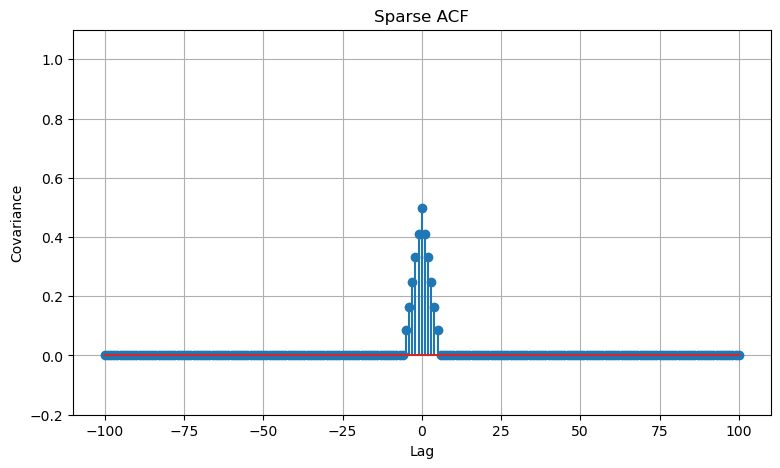

In [33]:
def MA_ACF(theta):
    """
    Compute the MA(q) ACF under parameter theta
    """
    q = len(theta) - 1
    return [sum([theta[k] * theta[k+t] for k in range(q-t+1)]) for t in range(q+1)]


def MA_approx(k, q):
    """
    Parameters
    ----------
    k : Centered ACF.
    q : MA model order.

    Returns
    -------
    The best (in l2) MA(q) approximation of k (centered).
    """
    # Truncate the ACF to match the MA(q) ACF support
    k_trunc = np.array(k[T:T+q+1])

    # Solve the least squares problem. We initialize with the square root of the original ACF to preserve the scaling (the MA ACF essentially squares the parameters).
    sol = least_squares(lambda theta: MA_ACF(theta) - k_trunc, np.sqrt(k_trunc))
    
    k_MA_trunc = MA_ACF(sol.x)
    return np.concatenate([np.zeros(T-q), k_MA_trunc[q:0:-1], k_MA_trunc, np.zeros(T-q)])

q = 5
k_s = MA_approx(k_res, q)

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k_s, "Sparse ACF", "Lag", "Covariance", (-0.2, 1.1))

# Combining: low-rank + sparse

The last step is to combine the low-rank and sparse components. The reconstructed approximate ACF will be the result of adding both kernels: $k_\text{rec} = k_\text{LR} + k_\text{S}$.

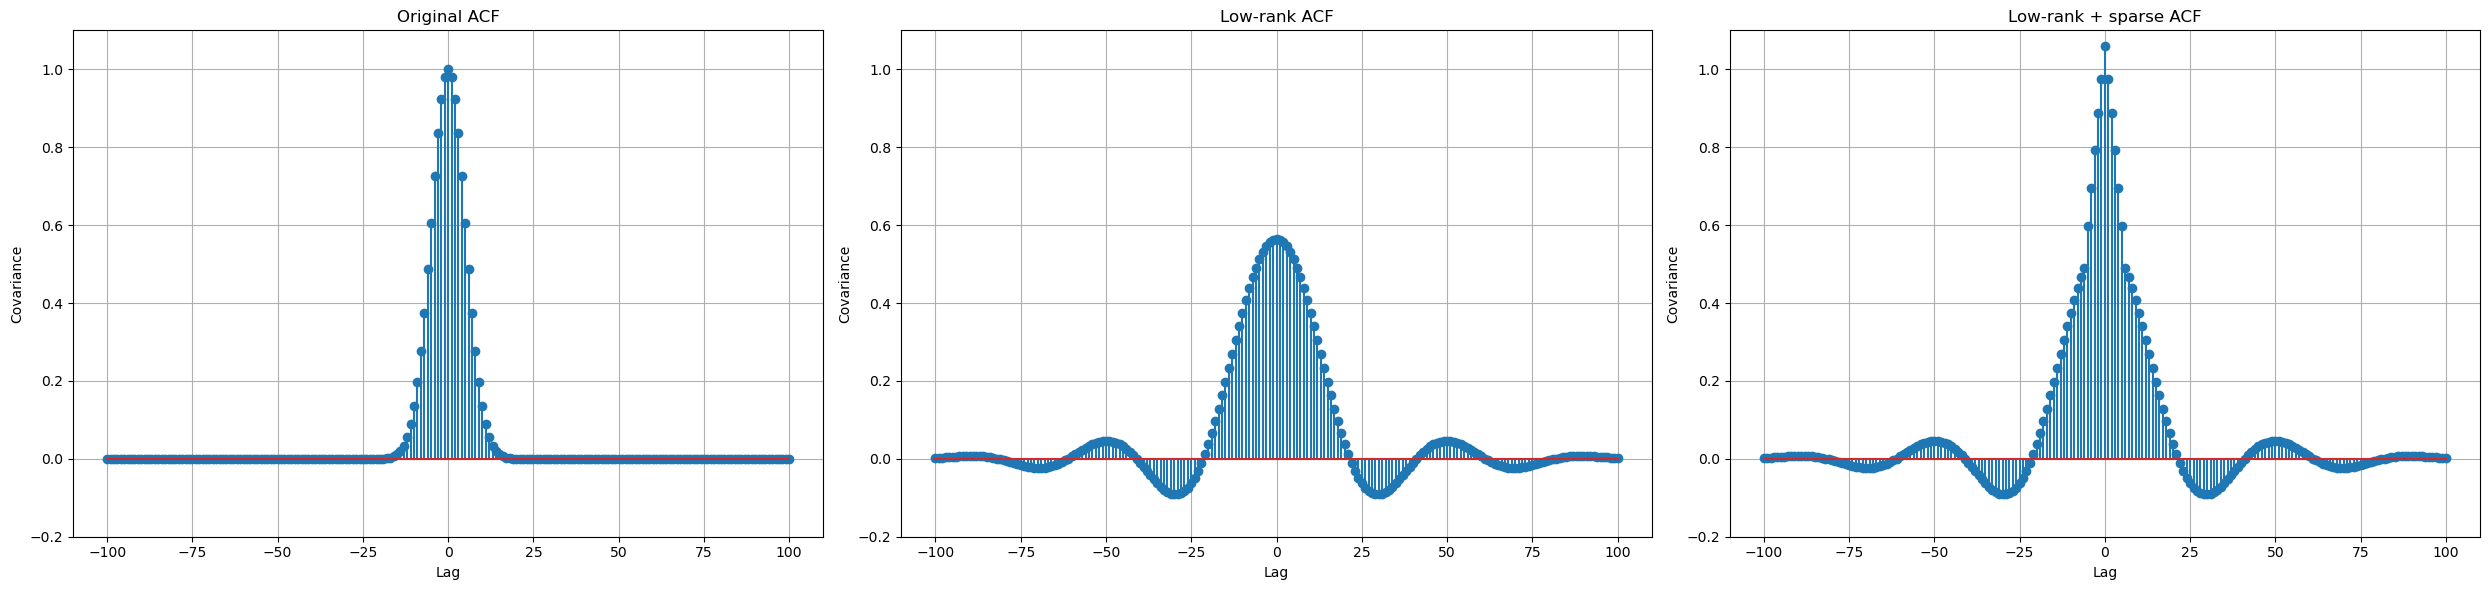

In [34]:
k_rec = k_lr + k_s

fig, ax = plt.subplots(1, 3, figsize=(25, 6))
stem_plot(ax[0], lags, k, "Original ACF", "Lag", "Covariance", (-0.2, 1.1))
stem_plot(ax[1], lags, k_lr, "Low-rank ACF", "Lag", "Covariance", (-0.2, 1.1))
stem_plot(ax[2], lags, k_rec, "Low-rank + sparse ACF", "Lag", "Covariance", (-0.2, 1.1))
plt.tight_layout()

We can also see how the residual plots compare.

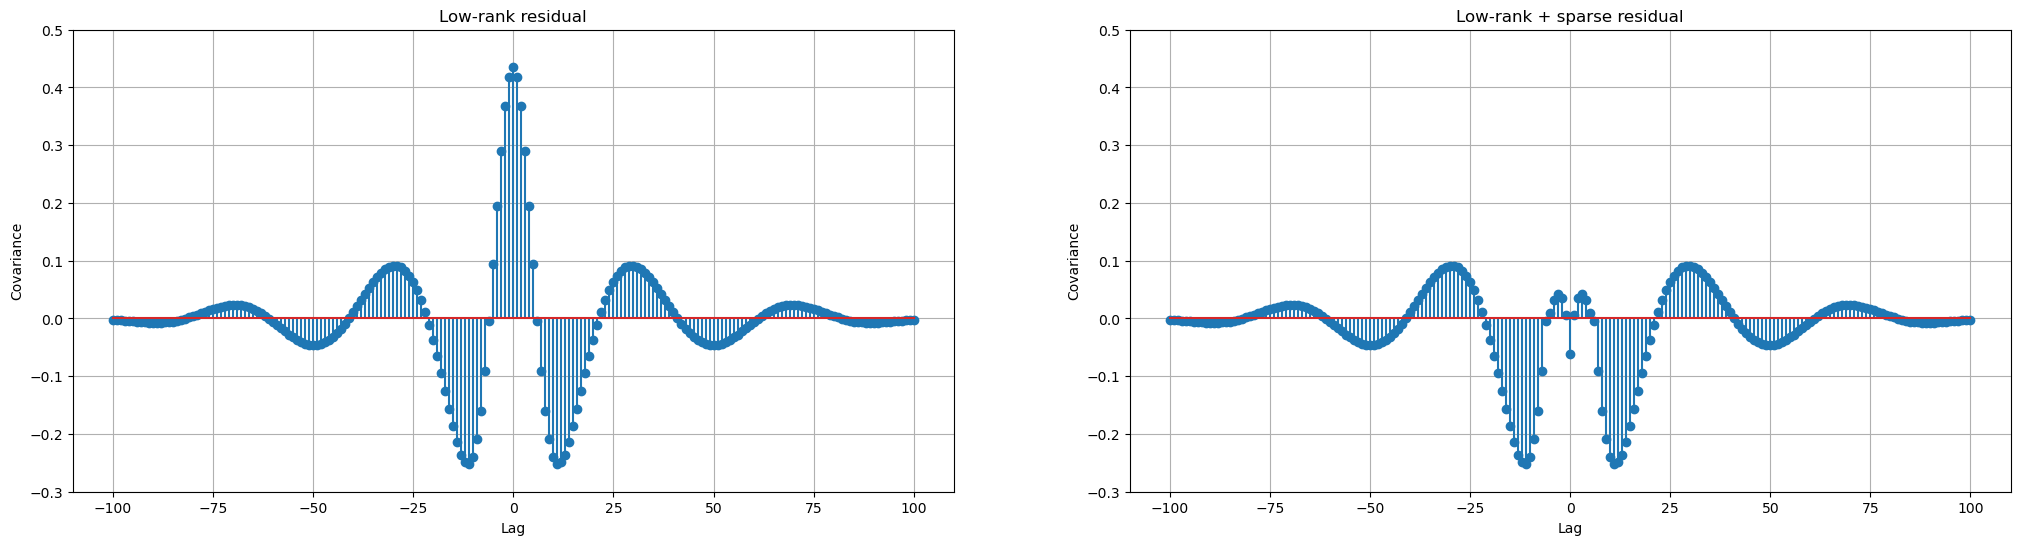

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
stem_plot(ax[0], lags, k_res, "Low-rank residual", "Lag", "Covariance", (-0.3, 0.5))
stem_plot(ax[1], lags, k - k_rec, "Low-rank + sparse residual", "Lag", "Covariance", (-0.3, 0.5))